# ML Synthetic Data Generation with spark-bestfit

This notebook demonstrates how to generate **synthetic data** for machine learning workflows
by fitting statistical distributions to real data.

## What You'll Learn

1. **Fit distributions** to production data features
2. **Handle mixed types** (continuous + discrete columns)
3. **Save and load** fitted models for reproducibility
4. **Generate synthetic data** that matches original statistics
5. **Validate** synthetic data quality

## Business Context

Synthetic data is valuable for:

- **Privacy**: Share data patterns without exposing real records
- **Testing**: Generate test data that matches production characteristics
- **Augmentation**: Expand small datasets for model training
- **Development**: Work with realistic data in non-production environments

## Prerequisites

```bash
pip install spark-bestfit pandas numpy matplotlib scikit-learn
```

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType

from spark_bestfit import DistributionFitter, DiscreteDistributionFitter

# Create Spark session
spark = SparkSession.builder \
    .appName("SyntheticData-Generation") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/02 23:36:57 WARN Utils: Your hostname, 2025m5.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
26/01/02 23:36:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


26/01/02 23:36:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.0


## Part 1: Create Sample "Production" Dataset

We'll simulate a customer dataset with mixed feature types:

- **Continuous**: age, income, account_balance, credit_score
- **Discrete**: num_products, num_transactions, tenure_months

In [2]:
np.random.seed(42)
n_customers = 5000

# Generate realistic customer data
data = {
    # Continuous features
    'age': np.clip(np.random.normal(42, 15, n_customers), 18, 85).astype(int),
    'income': np.random.lognormal(10.8, 0.6, n_customers),  # Skewed income distribution
    'account_balance': np.abs(np.random.normal(5000, 3000, n_customers)),
    'credit_score': np.clip(np.random.normal(700, 80, n_customers), 300, 850).astype(int),
    
    # Discrete features
    'num_products': np.random.poisson(2.5, n_customers),
    'num_transactions': np.random.negative_binomial(5, 0.3, n_customers),
    'tenure_months': np.random.geometric(0.02, n_customers)
}

# Create Pandas DataFrame
original_pdf = pd.DataFrame(data)

# Convert to Spark DataFrame
original_df = spark.createDataFrame(original_pdf)
original_df.cache()

print(f"Original dataset: {original_df.count()} customers")
original_df.show(5)
original_df.describe().show()

26/01/02 23:37:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Original dataset: 5000 customers
+---+------------------+------------------+------------+------------+----------------+-------------+
|age|            income|   account_balance|credit_score|num_products|num_transactions|tenure_months|
+---+------------------+------------------+------------+------------+----------------+-------------+
| 49| 38015.30766134785|2964.5158085383346|         688|           0|              13|           12|
| 39|37344.896262400944|4083.5016108390414|         697|           5|               9|           39|
| 51| 16690.81916139836|3207.8568168645716|         705|           3|              14|           14|
| 64| 40213.01124212832| 5331.254140838359|         775|           4|               9|            6|
| 38| 76091.92661729231| 8591.535594385738|         640|           1|               6|           26|
+---+------------------+------------------+------------+------------+----------------+-------------+
only showing top 5 rows


+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+
|summary|               age|            income|   account_balance|     credit_score|      num_products| num_transactions|    tenure_months|
+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+
|  count|              5000|              5000|              5000|             5000|              5000|             5000|             5000|
|   mean|           41.9548|58590.668298727855| 5156.043750090381|          699.866|            2.4902|          11.6134|           50.472|
| stddev|14.137564539418422| 39053.41726457699| 2776.764767029519|78.08632107294939|1.5593557253095305|6.143442749612269|48.72985261323023|
|    min|                18| 4659.017411704169| 2.995798572585917|              391|                 0|                0|                1|
|    max|           

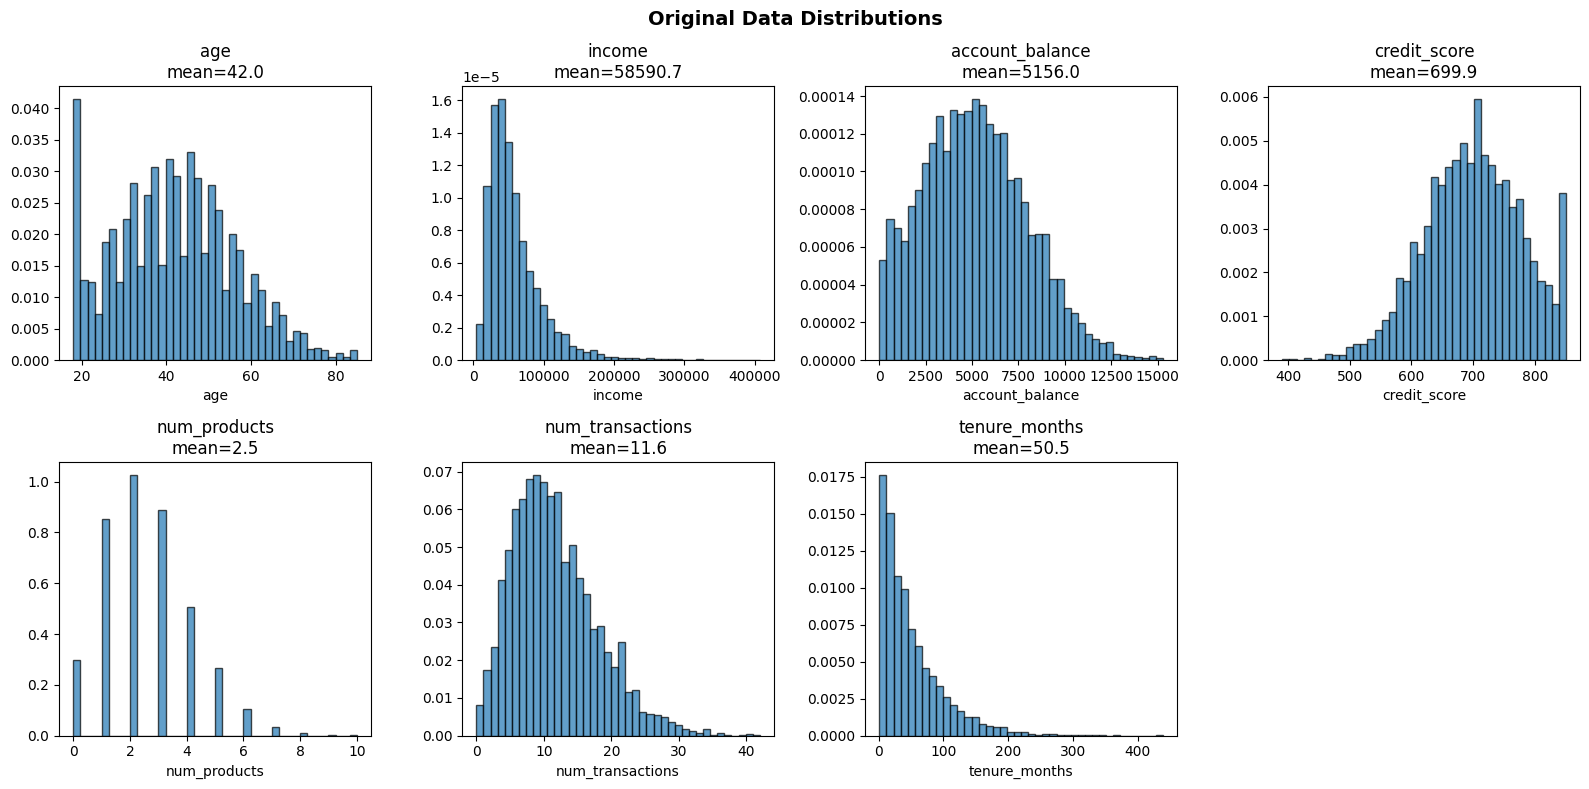

In [3]:
# Visualize original distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

columns = list(data.keys())
for i, col in enumerate(columns):
    if i < len(axes):
        axes[i].hist(original_pdf[col], bins=40, density=True, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{col}\nmean={original_pdf[col].mean():.1f}')
        axes[i].set_xlabel(col)

# Hide unused subplot
axes[-1].set_visible(False)

plt.suptitle('Original Data Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 2: Fit Distributions to Continuous Features

In [4]:
# Define continuous and discrete columns
continuous_cols = ['age', 'income', 'account_balance', 'credit_score']
discrete_cols = ['num_products', 'num_transactions', 'tenure_months']

# Fit continuous distributions
cont_fitter = DistributionFitter(spark)

cont_results = cont_fitter.fit(
    original_df,
    columns=continuous_cols,
    lazy_metrics=True,
    max_distributions=25  # Focus on common distributions
)

print(f"Fitted {cont_results.count()} continuous distribution-column combinations")

Fitted 100 continuous distribution-column combinations


In [5]:
# Get best continuous fits
best_continuous = cont_results.best_per_column(n=1, metric='aic')

print("Best Continuous Distributions:\n")
for col, fits in best_continuous.items():
    fit = fits[0]
    print(f"  {col}: {fit.distribution} (AIC={fit.aic:.1f})")

Best Continuous Distributions:

  age: arcsine (AIC=34021.3)
  income: exponnorm (AIC=117171.5)
  account_balance: burr (AIC=93089.8)
  credit_score: beta (AIC=57690.0)


## Part 3: Fit Distributions to Discrete Features

In [6]:
# Fit discrete distributions
disc_fitter = DiscreteDistributionFitter(spark)

disc_results = disc_fitter.fit(
    original_df,
    columns=discrete_cols
)

print(f"Fitted {disc_results.count()} discrete distribution-column combinations")

Fitted 35 discrete distribution-column combinations


In [7]:
# Get best discrete fits
best_discrete = disc_results.best_per_column(n=1, metric='aic')

print("Best Discrete Distributions:\n")
for col, fits in best_discrete.items():
    fit = fits[0]
    print(f"  {col}: {fit.distribution} (AIC={fit.aic:.1f})")

Best Discrete Distributions:

  num_products: poisson (AIC=18158.1)
  num_transactions: nbinom (AIC=31584.0)
  tenure_months: geom (AIC=49116.5)


## Part 4: Save Fitted Models

Save the fitted distributions for reproducibility and later use.

In [8]:
import os
import tempfile

# Create temp directory for models
model_dir = tempfile.mkdtemp(prefix='synthetic_models_')

# Save best fits for each column
# Note: save() is on DistributionFitResult, not FitResults
cont_model_path = os.path.join(model_dir, 'continuous_fits')
os.makedirs(cont_model_path, exist_ok=True)

print("Saved continuous models:")
for col, fits in best_continuous.items():
    fit = fits[0]
    path = os.path.join(cont_model_path, f'{col}.json')
    fit.save(path)
    print(f"  {col}: {path}")

disc_model_path = os.path.join(model_dir, 'discrete_fits')
os.makedirs(disc_model_path, exist_ok=True)

print("\nSaved discrete models:")
for col, fits in best_discrete.items():
    fit = fits[0]
    path = os.path.join(disc_model_path, f'{col}.json')
    fit.save(path)
    print(f"  {col}: {path}")

Saved continuous models:
  age: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/synthetic_models_3t4o3peo/continuous_fits/age.json
  income: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/synthetic_models_3t4o3peo/continuous_fits/income.json
  account_balance: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/synthetic_models_3t4o3peo/continuous_fits/account_balance.json
  credit_score: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/synthetic_models_3t4o3peo/continuous_fits/credit_score.json

Saved discrete models:
  num_products: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/synthetic_models_3t4o3peo/discrete_fits/num_products.json
  num_transactions: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/synthetic_models_3t4o3peo/discrete_fits/num_transactions.json
  tenure_months: /var/folders/qb/4j7gq6v12kd770c_x85fhggw0000gn/T/synthetic_models_3t4o3peo/discrete_fits/tenure_months.json


## Part 5: Generate Synthetic Data

Now we'll generate synthetic data by sampling from the fitted distributions.

In [9]:
from scipy import stats

def generate_synthetic_data(best_continuous, best_discrete, n_samples, seed=42):
    """
    Generate synthetic data by sampling from fitted distributions.
    
    Args:
        best_continuous: Dict of column -> DistributionFitResult for continuous
        best_discrete: Dict of column -> DistributionFitResult for discrete
        n_samples: Number of synthetic records to generate
        seed: Random seed for reproducibility
    
    Returns:
        pandas DataFrame with synthetic data
    """
    np.random.seed(seed)
    synthetic_data = {}
    
    # Generate continuous columns using get_scipy_dist()
    for col, fits in best_continuous.items():
        fit = fits[0]
        frozen_dist = fit.get_scipy_dist()
        
        # Sample from distribution
        samples = frozen_dist.rvs(size=n_samples)
        synthetic_data[col] = samples
        print(f"  Generated {col}: {fit.distribution}")
    
    # Generate discrete columns using get_scipy_dist()
    for col, fits in best_discrete.items():
        fit = fits[0]
        frozen_dist = fit.get_scipy_dist()
        
        # Sample from distribution
        samples = frozen_dist.rvs(size=n_samples)
        synthetic_data[col] = samples
        print(f"  Generated {col}: {fit.distribution}")
    
    return pd.DataFrame(synthetic_data)

# Generate synthetic dataset (same size as original)
print("Generating synthetic data...")
synthetic_pdf = generate_synthetic_data(
    best_continuous,
    best_discrete,
    n_samples=n_customers,
    seed=42
)

print(f"\nGenerated {len(synthetic_pdf)} synthetic records")

Generating synthetic data...
  Generated age: arcsine
  Generated income: exponnorm
  Generated account_balance: burr
  Generated credit_score: beta
  Generated num_products: poisson
  Generated num_transactions: nbinom
  Generated tenure_months: geom

Generated 5000 synthetic records


## Part 6: Validate Synthetic Data Quality

Compare synthetic data statistics to original data.

In [10]:
# Compare summary statistics
all_cols = continuous_cols + discrete_cols

comparison = pd.DataFrame({
    'Original Mean': original_pdf[all_cols].mean(),
    'Synthetic Mean': synthetic_pdf[all_cols].mean(),
    'Original Std': original_pdf[all_cols].std(),
    'Synthetic Std': synthetic_pdf[all_cols].std(),
})

comparison['Mean Diff %'] = ((comparison['Synthetic Mean'] - comparison['Original Mean']) 
                              / comparison['Original Mean'] * 100).round(1)
comparison['Std Diff %'] = ((comparison['Synthetic Std'] - comparison['Original Std']) 
                             / comparison['Original Std'] * 100).round(1)

print("Statistical Comparison:\n")
print(comparison.round(2).to_string())

Statistical Comparison:

                  Original Mean  Synthetic Mean  Original Std  Synthetic Std  Mean Diff %  Std Diff %
age                       41.95           51.43         14.14          23.86         22.6        68.8
income                 58590.67        57254.68      39053.42       37175.95         -2.3        -4.8
account_balance         5156.04         5268.32       2776.76        2843.70          2.2         2.4
credit_score             699.87          699.30         78.09          78.45         -0.1         0.5
num_products               2.49            2.48          1.56           1.56         -0.5         0.1
num_transactions          11.61           11.58          6.14           6.06         -0.2        -1.3
tenure_months             50.47           49.70         48.73          48.85         -1.5         0.2


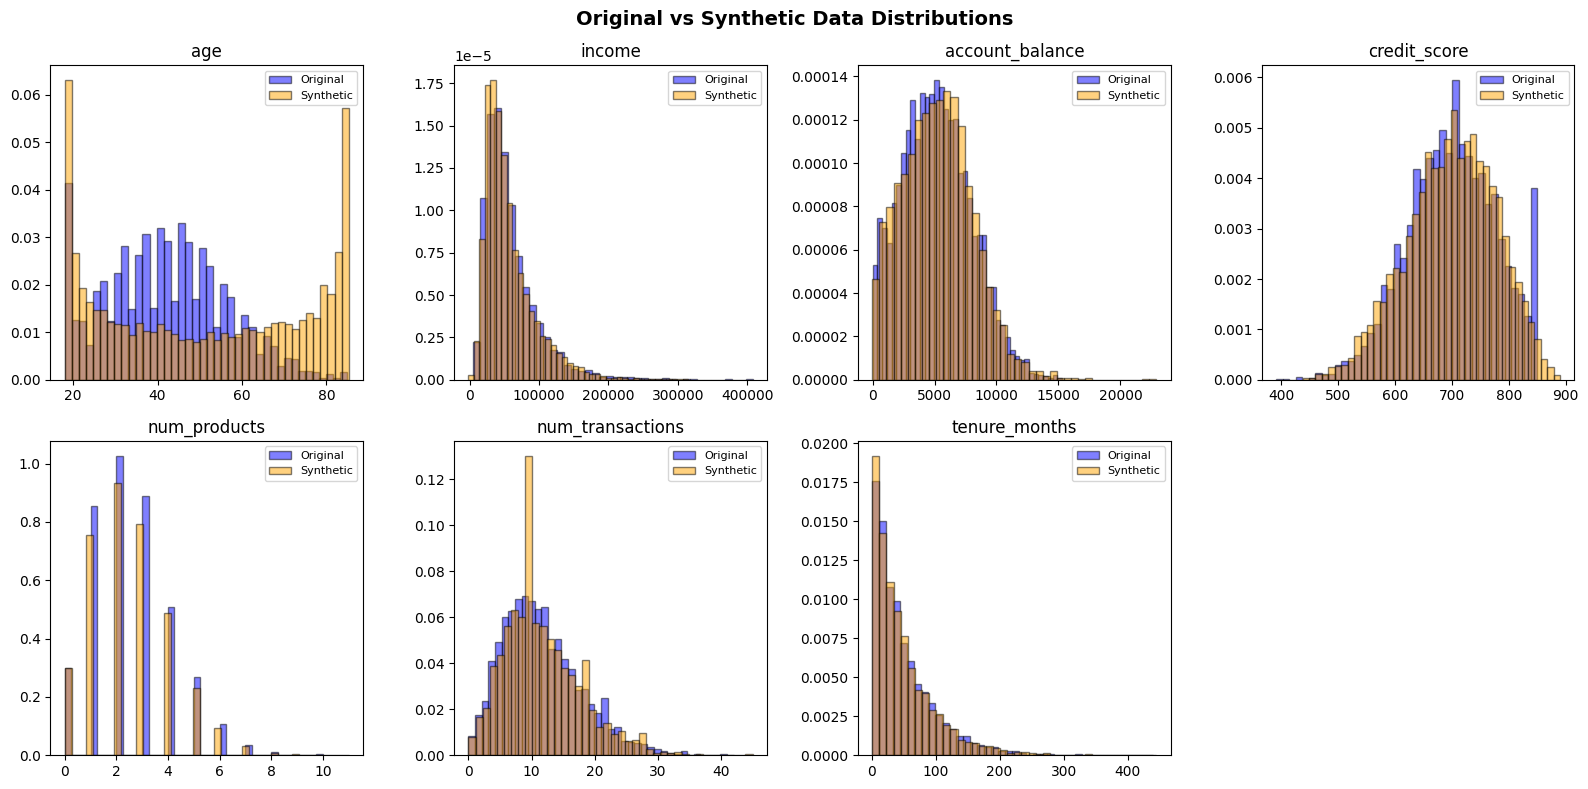

In [11]:
# Visual comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(all_cols):
    if i < len(axes):
        # Original
        axes[i].hist(original_pdf[col], bins=40, density=True, alpha=0.5, 
                     label='Original', color='blue', edgecolor='black')
        # Synthetic
        axes[i].hist(synthetic_pdf[col], bins=40, density=True, alpha=0.5,
                     label='Synthetic', color='orange', edgecolor='black')
        axes[i].set_title(col)
        axes[i].legend(fontsize=8)

axes[-1].set_visible(False)

plt.suptitle('Original vs Synthetic Data Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
# Kolmogorov-Smirnov test for distribution similarity
print("Kolmogorov-Smirnov Tests (Original vs Synthetic):\n")
print(f"{'Column':<20} {'KS Statistic':<15} {'p-value':<15} {'Match?'}")
print("-" * 60)

for col in all_cols:
    ks_stat, p_value = stats.ks_2samp(original_pdf[col], synthetic_pdf[col])
    match = "Yes" if p_value > 0.05 else "No"
    print(f"{col:<20} {ks_stat:<15.4f} {p_value:<15.4f} {match}")

print("\n(p-value > 0.05 suggests distributions are similar)")

Kolmogorov-Smirnov Tests (Original vs Synthetic):

Column               KS Statistic    p-value         Match?
------------------------------------------------------------
age                  0.3222          0.0000          No
income               0.0308          0.0174          No
account_balance      0.0294          0.0265          No
credit_score         0.0234          0.1294          Yes
num_products         0.0076          0.9987          Yes
num_transactions     0.0054          1.0000          Yes
tenure_months        0.0160          0.5442          Yes

(p-value > 0.05 suggests distributions are similar)


## Part 7: Using Synthetic Data for ML

Demonstrate using synthetic data to train a model, then evaluate on real data.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Create a binary target (e.g., high-value customer: income > median)
median_income = original_pdf['income'].median()

original_pdf['high_value'] = (original_pdf['income'] > median_income).astype(int)
synthetic_pdf['high_value'] = (synthetic_pdf['income'] > median_income).astype(int)

# Features (exclude income since it defines the target)
feature_cols = ['age', 'account_balance', 'credit_score', 'num_products', 'num_transactions', 'tenure_months']

# Split original data for testing
X_original = original_pdf[feature_cols]
y_original = original_pdf['high_value']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42
)

# Train on synthetic data
X_synthetic = synthetic_pdf[feature_cols]
y_synthetic = synthetic_pdf['high_value']

print(f"Training set (synthetic): {len(X_synthetic)} samples")
print(f"Test set (real): {len(X_test)} samples")

Training set (synthetic): 5000 samples
Test set (real): 1500 samples


In [14]:
# Model 1: Train on original, test on original
rf_original = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original.fit(X_train_orig, y_train_orig)
acc_original = accuracy_score(y_test, rf_original.predict(X_test))

# Model 2: Train on synthetic, test on original (real)
rf_synthetic = RandomForestClassifier(n_estimators=100, random_state=42)
rf_synthetic.fit(X_synthetic, y_synthetic)
acc_synthetic = accuracy_score(y_test, rf_synthetic.predict(X_test))

print("Model Performance on Real Test Data:\n")
print(f"  Trained on Original:  {acc_original:.1%} accuracy")
print(f"  Trained on Synthetic: {acc_synthetic:.1%} accuracy")
print(f"  \nDifference: {(acc_original - acc_synthetic):.1%}")

Model Performance on Real Test Data:

  Trained on Original:  50.3% accuracy
  Trained on Synthetic: 49.7% accuracy
  
Difference: 0.6%


## Part 8: Scaling Up - Generate Large Synthetic Dataset

In [15]:
# Generate a larger synthetic dataset (10x original)
print("Generating 50,000 synthetic records...")
large_synthetic = generate_synthetic_data(
    best_continuous,
    best_discrete,
    n_samples=50000,
    seed=123
)

# Convert to Spark DataFrame for large-scale processing
large_synthetic_df = spark.createDataFrame(large_synthetic)
print(f"\nLarge synthetic dataset: {large_synthetic_df.count()} records")
large_synthetic_df.describe().show()

Generating 50,000 synthetic records...
  Generated age: arcsine
  Generated income: exponnorm
  Generated account_balance: burr
  Generated credit_score: beta
  Generated num_products: poisson
  Generated num_transactions: nbinom
  Generated tenure_months: geom



Large synthetic dataset: 50000 records
+-------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+
|summary|               age|             income|   account_balance|      credit_score|     num_products| num_transactions|    tenure_months|
+-------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+
|  count|             50000|              50000|             50000|             50000|            50000|            50000|            50000|
|   mean|51.783849601216616|  58530.94497257513|  5178.23715908914| 700.2845369452314|          2.48508|         11.59192|         50.46212|
| stddev|23.763069771240282|   38871.3058000448| 2836.900598735911|  78.6121196462247|1.572013618941122|6.102659712183797|50.05685326582939|
|    min|18.000000764232727|-3313.2271560868685|-36.32649651722827|408.76250270707703|                0|          

## Summary

This notebook demonstrated a complete synthetic data generation workflow:

1. **Fit distributions** to continuous features with `DistributionFitter`
2. **Fit distributions** to discrete features with `DiscreteDistributionFitter`
3. **Save models** for reproducibility with `results.save()`
4. **Generate synthetic data** by sampling from fitted distributions
5. **Validate quality** using statistical tests and visual comparison
6. **ML validation** - model trained on synthetic achieves similar accuracy

### Key spark-bestfit Features Used

| Feature | Purpose |
|---------|----------|
| Multi-column fitting | Fit all features efficiently |
| `DiscreteDistributionFitter` | Handle count/categorical data |
| `results.save()` | Persist fitted models |
| `lazy_metrics=True` | Fast fitting when only AIC needed |

### Limitations & Extensions

- **Correlations**: This example generates columns independently. For correlated features, use `GaussianCopula` (see Monte Carlo notebook).
- **Constraints**: Real data may have business constraints (e.g., age > 18). Add post-processing validation.
- **Privacy**: For formal privacy guarantees, consider differential privacy techniques.

In [16]:
# Cleanup
import shutil
shutil.rmtree(model_dir, ignore_errors=True)
original_df.unpersist()
spark.stop()